In [1]:
! which python

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/bin/python


In [3]:
import pandas as pd
import json
import os
import tarfile
from tqdm.notebook import tqdm
from flatten_dict import flatten

In [4]:
DATA_DIR = "/cluster/work/cotterell/mm_swissai/datasets"
DF_PATH = os.path.join(DATA_DIR, "overview.parquet")

In [5]:
os.listdir(DATA_DIR)

['howto100m', 'hdvila', 'moments_in_time']

In [6]:
# TODO clean up file structure
datasets = {
    "moments_in_time": os.path.join(DATA_DIR, "moments_in_time", "moments_in_time"),
    "howto100m": os.path.join(DATA_DIR, "howto100m"),
    "hdvila": os.path.join(DATA_DIR, "hdvila", "10000_hd_vila_shuffled"),
}

# Aggregate metadata

In [7]:
include_keys = [
    "url",
    "key",
    "status",
    "error_message",
    "yt_meta_dict.info.id",
    "yt_meta_dict.info.title",
    "yt_meta_dict.info.thumbnail",
    "yt_meta_dict.info.channel_id",
    "yt_meta_dict.info.duration",
    "yt_meta_dict.info.view_count",
    "yt_meta_dict.info.average_rating",
    "yt_meta_dict.info.age_limit",
    "yt_meta_dict.info.webpage_url",
    #"yt_meta_dict.info.categories",
    #"yt_meta_dict.info.tags",
    "yt_meta_dict.info.comment_count",
    "yt_meta_dict.info.like_count",
    "yt_meta_dict.info.channel",
    "yt_meta_dict.info.uploader_id",
    "yt_meta_dict.info.channel_follower_count",
    "yt_meta_dict.info.upload_date",
    "yt_meta_dict.info.format",
    "yt_meta_dict.info.format_id",
    "yt_meta_dict.info.filesize_approx",
    "yt_meta_dict.info.tbr",
    "yt_meta_dict.info.width",
    "yt_meta_dict.info.height",
    "yt_meta_dict.info.resolution",
    "yt_meta_dict.info.fps",
    "yt_meta_dict.info.dynamic_range",
    "yt_meta_dict.info.vcodec",
    "yt_meta_dict.info.stretched_ratio",
    "yt_meta_dict.info.aspect_ratio",
    "yt_meta_dict.info.acodec",
    "yt_meta_dict.info.abr",
    "yt_meta_dict.info.asr",
    "yt_meta_dict.info.audio_channels",
]

In [8]:
import tempfile
import imageio_ffmpeg as iio_ffmpeg


def get_video_duration(filehandle):
    # TODO use ffprobe and avoid tempfile
    try:
        with tempfile.NamedTemporaryFile(delete=True) as tmp_file:
            tmp_file.write(filehandle.read())
            tmp_file_path = tmp_file.name

            reader = iio_ffmpeg.read_frames(tmp_file_path)
            info = next(reader)
            duration = info['duration']
            return duration
    except:
        return None


    
def process_shard(dataset_dir, dataset_name, shard_key, include_keys, overwrite=False):
    """
    Read all metadata files in a shard and summarize them in a parquet file
    """
    tar_fname = os.path.join(dataset_dir, shard_key + ".tar")
    overview_fname = os.path.join(dataset_dir, shard_key + "_meta.parquet") # TODO v2d already creates a .parquet, reuse that instead of _meta.parquet
    
    if os.path.exists(overview_fname) and not overwrite:
        return overview_fname
 
    df = pd.DataFrame(columns=include_keys + ["shard_key", "original_dataset", "video_duration"])
    with tarfile.open(os.path.join(dataset_dir, tar_fname), "r") as tar:
        for json_fname in tar.getnames():
            if not json_fname.endswith(".json"):
                continue

            idx = len(df)
            with tar.extractfile(json_fname) as f:
                row = flatten(json.loads(f.read()), reducer="dot")
                
            if row.get("status") != "success":
                continue

            row = {k: row.get(k, None) for k in include_keys}
            row["shard_key"] = shard_key
            row["original_dataset"] = dataset_name
            if row.get("yt_meta_dict.info.duration") is None:
                # e.g. MiT is not from youtube -> read length, this is slow
                with tar.extractfile(json_fname.replace(".json", ".mp4")) as f_video:
                    row["video_duration"] = get_video_duration(f_video)
            else:
                row["video_duration"] = row["yt_meta_dict.info.duration"]

                                              

            df.loc[idx] = row
            
    df.to_parquet(overview_fname)
    return overview_fname


In [9]:
from concurrent.futures import ProcessPoolExecutor, as_completed  # this should probably be computed via v2d instead
assert not os.path.exists(DF_PATH), "overview dataframe already computed"

df = pd.DataFrame(columns=include_keys + ["shard_key", "original_dataset"])

n_workers = 32
print(f"Processing in parallel with {n_workers} workers (make sure this makes sense given your number of cores)")

for dataset_name, dataset_dir in datasets.items():
    shard_keys = sorted(x.replace(".tar", "") for x in os.listdir(dataset_dir) if x.endswith(".tar"))
    n_shards = len(shard_keys)
    
    # process shards in parallel
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = [
            executor.submit(
                process_shard,
                dataset_dir,
                dataset_name,
                shard_key,
                include_keys,
                False
            ) for shard_key in shard_keys
        ]
        
        results = []
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing shards for {dataset_name}"):
            shard_overview_fname = future.result()
            results.append(shard_overview_fname)
            df_shard = pd.read_parquet(shard_overview_fname)
            df = pd.concat([df, df_shard], ignore_index=True)
            
df.to_parquet(DF_PATH)           

Processing in parallel with 32 workers (make sure this makes sense given your number of cores)


Processing shards for moments_in_time:   0%|          | 0/305 [00:00<?, ?it/s]

Processing shards for howto100m:   0%|          | 0/3 [00:00<?, ?it/s]

Processing shards for hdvila:   0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
DF_PATH = "/cluster/scratch/scanton/overview.parquet"
df.to_parquet(DF_PATH)

# Read Metadata

In [45]:
df = pd.read_parquet(DF_PATH)

# Analyze

In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
summary_df = df.groupby('original_dataset')['video_duration'].agg(
    Total_Num_Videos = 'count',
    Total_Duration_Seconds = 'sum',
    Total_Duration_Hours = lambda x: x.sum() / 3600,
)
display(summary_df)

,Total_Num_Videos,Total_Duration_Seconds,Total_Duration_Hours
original_dataset,,,
hdvila,9066,3411028.28,947.507856
howto100m,196,49860.40,13.850111
moments_in_time,757764,2287179.56,635.327656


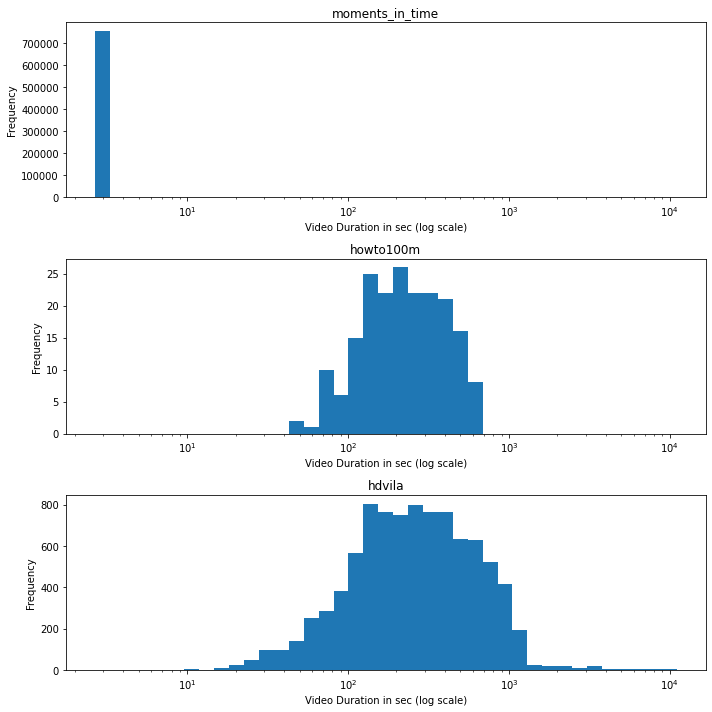

In [48]:
fig, axs = plt.subplots(df.original_dataset.nunique(), figsize=(10, 10))

bins = np.logspace(np.log10(df.video_duration.min()), np.log10(df.video_duration.max()), num=40)


for ax, ds_name in zip(axs, df.original_dataset.unique()):

    ax.hist(df[df.original_dataset == ds_name].video_duration, bins=bins)
    ax.set_xscale("log")
    
    # Labeling
    ax.set_title(ds_name)
    ax.set_xlabel('Video Duration in sec (log scale)')
    ax.set_ylabel('Frequency')

fig.tight_layout()